In [40]:
import struct
import array
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import poisson

In [45]:
class Event:
    def __init__(self, event_number, timestamp, sampling_rate, time_resolution, waveform):
        self.EventNumber = event_number
        self.Timestamp = timestamp
        self.SamplingRate = sampling_rate
        self.TimeResolution = time_resolution
        self.Waveform = waveform

class ReadRawFile:
    def __init__(self, input_raw_file):
        self.input_raw_file = input_raw_file

    def read_raw_data(self):
        data_points_in_one_ms = 125000
        signal_time = 600e-3 # write in ms
        with open(self.input_raw_file, 'rb') as myfile:
            while True:
                try:
                    event_number = struct.unpack("I", myfile.read(4))[0]
                    myfile.seek(0, 1)
                    timestamp = struct.unpack("Q", myfile.read(8))[0]
                    myfile.seek(0, 1)
                    sampling_rate = struct.unpack("I", myfile.read(4))[0]
                    myfile.seek(0, 1)
                    time_resolution = struct.unpack("Q", myfile.read(8))[0]

                    wf = []
                    for _ in range(int(data_points_in_one_ms*signal_time)): # 125000 is 1ms
                        myfile.seek(0, 1)
                        wf.append(struct.unpack("f", myfile.read(4))[0])

                    waveform = array.array('f', wf)

                    event_object = Event(event_number, timestamp, sampling_rate, time_resolution, waveform)
                    yield event_object  
                except struct.error:
                    break

0 75000 8 24484356 

1 75000 8 30552512 e 1

2 75000 8 71747467 e 2

3 75000 8 85466245 e 3

4 75000 8 107111695  4

5 75000 8 111040062  5

6 75000 8 131344063  6

7 75000 8 132720785  7

8 75000 8 142132156  8

9 75000 8 142634548  9

10 75000 8 144549281 10

11 75000 8 146402595 11

12 75000 8 184251888 12

13 75000 8 227922362 13

14 75000 8 232668148 14

15 75000 8 306792875 15

16 75000 8 313561792 16

17 75000 8 356080745 17

18 75000 8 382259026 18

19 75000 8 394403676 19

20 75000 8 419850134 20

21 75000 8 460802351 21

22 75000 8 472676992 22

23 75000 8 494652795 23

24 75000 8 494765950 24

25 75000 8 503321656 25

26 75000 8 526157202 26

27 75000 8 530346837 27

28 75000 8 544626718 28

29 75000 8 555779893 29

30 75000 8 602701127 30

32 75000 8 606069993 31

33 75000 8 612513914 32

34 75000 8 616588159 33

35 75000 8 625593609 34

36 75000 8 645636593 35

37 75000 8 651745104 36

38 75000 8 674294794 37

39 75000 8 678904250 38

40 75000 8 700919036 39

41 75000 8 72

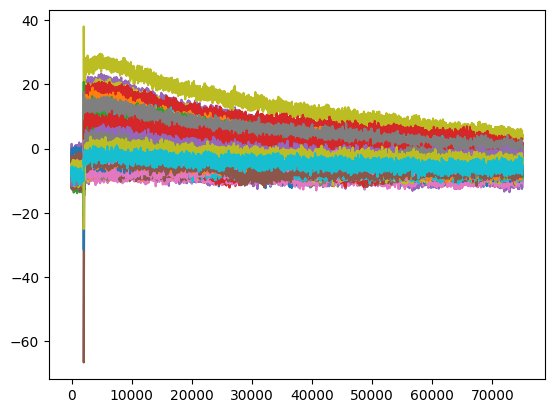

In [80]:
filename = "/Users/arathisuraj/Desktop/Feb1_LArCombo_ShortDrift_dig2-192.168.0.254_CH0_20240201125250-09.bin"
timestamps = []
max_vals = []
max_ind = []

def main():
    global timestamps
    input_raw_file = filename
    flag = 0
    events = ReadRawFile(input_raw_file) # build event from raw file
    
    i=0
    j=0
    for ievent in events.read_raw_data(): # loop over all the events
        print(ievent.EventNumber, ievent.SamplingRate, ievent.TimeResolution, ievent.Timestamp, "\n")
        print("Now working on trace " + str(j + 1), end='\r')
        j = j + 1
        average_wf = np.zeros(int(125000*600e-3))
        average_wf = np.array(ievent.Waveform)
        # test_array = -average_wf/counter
        
        selected_wf = average_wf
        # selected_wf = average_wf[0:3000]
        if(max(selected_wf)>5):
            plt.plot(selected_wf)
            # The device collects a sample every 8 ns and Timestamp shows which sample since the start of the data collection that this trigger happened at
            # Therefore, just multiply Timestamp by 8 ns to get the real time elapsed since program start that this event occured at
            print(selected_wf.shape)
            timestamps.append(ievent.Timestamp)
            max_vals.append(max(selected_wf))
            max_ind.append(selected_wf.argmax())
            i+=1
        #flag += 1
        
    print(str(i)+' events normal out of '+str(j))

if __name__ == "__main__":
    main()

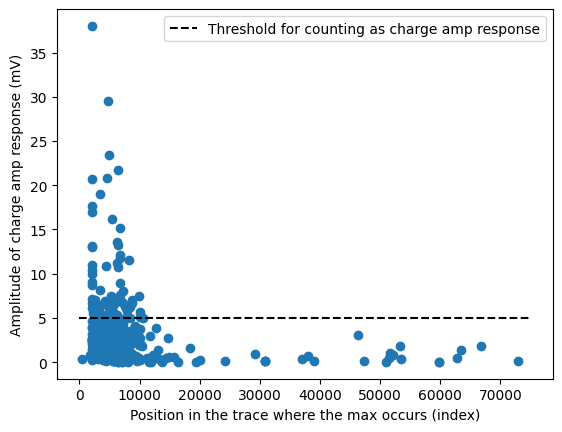

In [89]:
plt.scatter(max_ind, max_vals)
plt.xlabel("Position in the trace where the max occurs (index)")
plt.ylabel("Amplitude of charge amp response (mV)")
plt.hlines(5, 0, 75000, ls="--", color="black", label="Threshold for counting as charge amp response")
plt.legend()

In [93]:
above_5 = 0
for val in max_vals:
    if val >= 5:
        above_5+=1
event_rate = above_5/1317
print("Event rate is %.05f events/sec. Frequency is %.05f Hz" % (event_rate, 1/event_rate))

Event rate is 0.05315 events/sec. Frequency is 18.81429 Hz


In [112]:
# We only care about the max values after the pre-trigger time (16 us) is over. max_ind contains all indices from 0 - 75000. As long as we filter 
# this list to only include indices after 2000 (ie, 16 us), we'll be good!
max_ind_after_pretrig = []
for val in max_ind:
    if val > 2000:
        max_ind_after_pretrig.append(val)
print(len(max_ind_after_pretrig), "\n", max_ind_after_pretrig)

298 
 [2048, 6664, 4256, 6537, 3134, 3514, 4203, 16336, 2921, 5518, 7683, 4891, 8618, 4753, 4951, 6057, 6481, 2036, 11329, 9838, 3922, 8884, 5060, 4688, 10121, 6296, 6769, 2031, 2989, 3082, 8541, 2040, 2508, 10442, 2028, 3419, 7571, 4673, 4080, 3027, 4469, 6277, 5667, 3646, 4086, 3465, 7291, 2030, 5134, 20095, 6352, 6266, 4028, 7575, 7354, 2035, 3957, 7877, 7988, 5504, 4267, 7156, 7409, 6511, 4082, 6691, 6045, 2034, 8564, 5651, 5820, 2044, 9331, 4147, 5103, 2043, 8398, 18386, 6372, 30907, 2607, 11292, 3685, 7289, 2432, 7670, 2027, 4380, 7917, 7040, 5564, 6814, 4358, 5226, 7422, 6737, 9872, 5851, 4283, 6173, 5033, 4965, 6261, 7963, 6261, 5224, 7006, 5319, 5599, 6357, 2032, 5758, 2053, 5589, 5648, 7125, 7242, 5436, 2488, 2597, 51474, 3802, 13223, 9427, 30913, 2691, 2028, 3156, 5411, 9970, 4844, 6017, 38046, 9583, 3286, 7854, 6572, 6450, 4804, 2376, 5563, 4795, 9160, 4539, 10075, 3270, 7017, 8786, 2569, 8275, 4144, 5983, 9077, 51635, 46268, 53357, 5498, 4350, 5938, 2717, 19428, 5621, 2030

In [131]:
print(max_ind_after_pretrig)

[2048, 6664, 4256, 6537, 3134, 3514, 4203, 16336, 2921, 5518, 7683, 4891, 8618, 4753, 4951, 6057, 6481, 2036, 11329, 9838, 3922, 8884, 5060, 4688, 10121, 6296, 6769, 2031, 2989, 3082, 8541, 2040, 2508, 10442, 2028, 3419, 7571, 4673, 4080, 3027, 4469, 6277, 5667, 3646, 4086, 3465, 7291, 2030, 5134, 20095, 6352, 6266, 4028, 7575, 7354, 2035, 3957, 7877, 7988, 5504, 4267, 7156, 7409, 6511, 4082, 6691, 6045, 2034, 8564, 5651, 5820, 2044, 9331, 4147, 5103, 2043, 8398, 18386, 6372, 30907, 2607, 11292, 3685, 7289, 2432, 7670, 2027, 4380, 7917, 7040, 5564, 6814, 4358, 5226, 7422, 6737, 9872, 5851, 4283, 6173, 5033, 4965, 6261, 7963, 6261, 5224, 7006, 5319, 5599, 6357, 2032, 5758, 2053, 5589, 5648, 7125, 7242, 5436, 2488, 2597, 51474, 3802, 13223, 9427, 30913, 2691, 2028, 3156, 5411, 9970, 4844, 6017, 38046, 9583, 3286, 7854, 6572, 6450, 4804, 2376, 5563, 4795, 9160, 4539, 10075, 3270, 7017, 8786, 2569, 8275, 4144, 5983, 9077, 51635, 46268, 53357, 5498, 4350, 5938, 2717, 19428, 5621, 2030, 1280

[33.  0.  0.  1.  1.  1.  3.  2.  4.  2.  1.  2.  2.  1.  3.  3.  2.  2.
  0.  3.  3.  1.  1.  1.  0.  4.  2.  1.  3.  4.  1.  3.  3.  1.  2.  1.
  0.  2.  1.  3.  3.  4.  2.  3.  0.  4.  3.  3.  2.  6.  5.  4.  1.  2.
  1.  2.  5.  2.  3.  7.  4.  5.  2.  2.  2.  2.  4.  2.  1.  0.  3.  2.
  4.  1.  3.  3.  2.  1.  3.  2.  0.  0.  3.  3.  2.  0.  0.  1.  2.  3.
  1.  1.  2.  0.  2.  1.  1.  1.  1.  1.  1.  0.  1.  0.  2.  1.  1.  2.
  1.  0.  2.  1.  2.  1.  3.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  1.  1.  0.  0.  1.  0.  1.  0.  1.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0

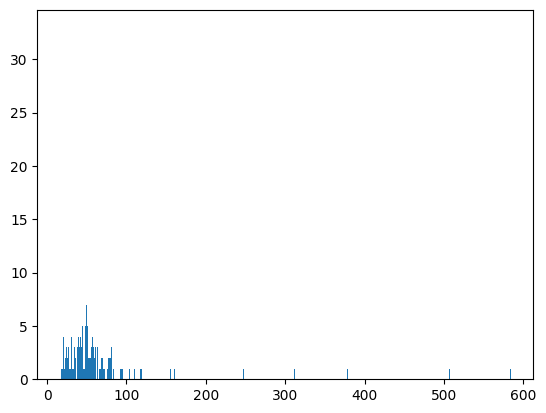

In [167]:
# We now convert that array to a time array and that should roughly tell us how long it took since the trigger to see a charge amp response. Fitting
# a Gaussian (or half-Gaussian) might help us get a rough idea of the drift time.
bin = 1000
drift_times = np.array(max_ind_after_pretrig)*8e-9*1e6 # Convert into seconds and then back into microseconds
n, bins, p = plt.hist(drift_times, bins=bin)
print(n)

In [168]:
# Fitting a half-Gaussian to this data
from scipy.optimize import curve_fit
def Gauss(x, A, mean, std):
  gauss = A*np.exp(-(x-mean)**2/(2*std**2))
  return gauss

In [172]:
popt, pcov = curve_fit(Gauss, bins[1:len(bins)-1], n[1:len(n)], p0 = [8, 50, 10])
print(popt)
print(np.sqrt(np.diag(pcov)))

[ 2.72566427 44.63302726 21.11046535]
[0.07458261 0.7349526  0.82072354]


Text(0, 0.5, 'Counts')

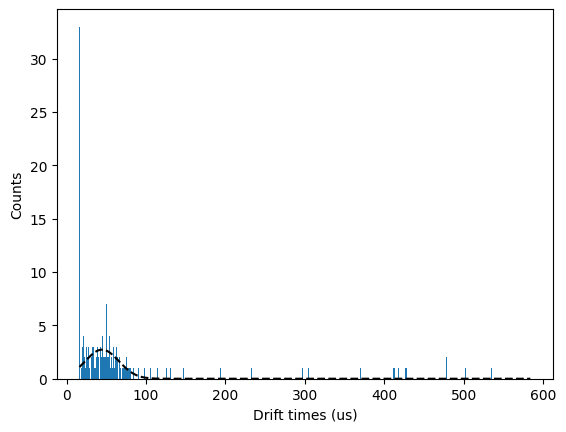

In [173]:
plt.plot(bins, Gauss(bins, *popt), color="black", ls="--")
n2, b2, p2 = plt.hist(drift_times, bins=bin)

plt.xlabel("Drift times (us)")
plt.ylabel("Counts")